## Data figures of CNN performance

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import os, sys
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
import pickle
import tabulate
# import segmentation_models_pytorch as smp
lcv.set_fontsize(10)
path_dict = loadpaths.loadpaths()

Font size is set to 10


## Prep data for both figures:

In [6]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_detailed = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_tile_outlines = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == 'SK1357'].iloc[0]['geometry']
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines_2 = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')
eval_patch_outlines_concat = pd.concat([eval_patch_outlines, eval_patch_outlines_2], axis=0)

df_detailed = lca.test_validity_geometry_column(df_detailed)
df_detailed = df_detailed[df_detailed['Class_low'] != '0']

## Prep data for distribution plots:
dict_pols_detailed_rand = lca.get_pols_for_tiles(df_pols=df_detailed, col_name='tile_patch',
                        df_tiles=eval_patch_outlines_concat[np.logical_or(eval_patch_outlines_concat['RAND_ANNOT'] == 1, eval_patch_outlines_concat['SEL_ANNOT'] == 1)], 
                        col_ind_name='Class_low', col_class_name='Class_low')
# dict_tile_patches
dict_pols_detailed_rand = {key[:7] + 'patch' + key[8:].zfill(3): val for key, val in dict_pols_detailed_rand.items()}
dict_area_0 = {}
for tp, df in dict_pols_detailed_rand.items():
    if '0' in df['Class_low'].values:
        dict_area_0[tp] = df[df['Class_low'] == '0']['geometry'].area.sum()
    else:
        dict_area_0[tp] = 0

def map_low_to_high_level(code):
    if code == 'F3a':
        return 'D'
    elif code == 'F3d':
        return 'E'
    else:
        return code[0]
    
for key in dict_pols_detailed_rand.keys():
    dict_pols_detailed_rand[key]['Class_high'] = dict_pols_detailed_rand[key]['Class_low'].apply(map_low_to_high_level)


Geometry Ring Self-intersection[405166.645500001 354069.537799999] for inds [3448]
Attempting to make valid
Done
Geometry Ring Self-intersection[407379.638966848 352904.669116294] for inds [465]
Attempting to make valid
Done
Geometry Ring Self-intersection[407495.557080073 405488.00284208] for inds [1722]
Attempting to make valid
Done
Geometry Ring Self-intersection[407588.8603 352489.939199999] for inds [1316]
Attempting to make valid
Done
Geometry Ring Self-intersection[407597.556900001 352132.544300001] for inds [482]
Attempting to make valid
Done
Geometry Ring Self-intersection[408576.001399294 352149.6823] for inds [4273]
Attempting to make valid
Done
Geometry Ring Self-intersection[414871.025378596 372829.307805445] for inds [2296]
Attempting to make valid
Done
Geometry Ring Self-intersection[415825.015405168 368957.661992135] for inds [1533]
Attempting to make valid
Done
Geometry Ring Self-intersection[421050.500000001 396097.5] for inds [2423]
Attempting to make valid
Done
Geom

100%|██████████| 1028/1028 [00:04<00:00, 217.84it/s]


0 tiles were empty: []


NameError: name 'LCU_main' is not defined

In [4]:
dict_colour = {'train': 'blue', 'test': 'red',
               'C': '#0e8212',
                'D': '#a33b1a',
               'E': '#465E85'}

## Main class figure:

In [8]:
model_path_main = 'LCU_2023-03-24-0222.data'
LCU_main = lcm.load_model(filename=model_path_main)
LCU_main.eval()

path_mapping_dict_main = LCU_main.dict_training_details['path_mapping_dict']
with open(LCU_main.dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
            dict_tile_patches = pickle.load(f)
            tile_patch_train = dict_tile_patches['train']
            tile_patch_test = dict_tile_patches['test']
dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
                            '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
       
test_ds_main = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU_main.preprocessing_func, 
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False,
                            list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict_main)
test_ds_main.remove_no_class_patches()
# test_dl = torch.utils.data.DataLoader(test_ds_main, batch_size=10, num_workers=8)

Loaded LCU_2023-03-24-0222
loss_function is cross_entropy
n_max_epochs is 90
LandCoverUNet class using CrossEntropyLoss()
main_categories_F3inDE_noFGH training using randomly split eval patch data. cross_entropy resnet50 90 epochs
Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__main_categories_F3inDE_noFGH__2023-03-17-0957.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 453.21it/s]

Removed 1 patches with no class


Removing NO CLASS from confusion matrix


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


adding scrub
adding wetland
adding transport


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>
(3, 512, 512) <class 'numpy.ndarray'>


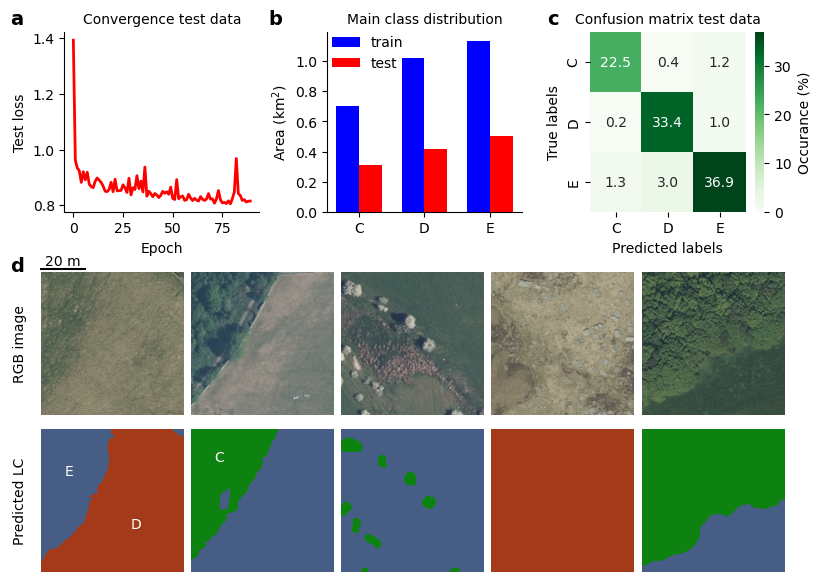

In [6]:
save_fig = False

fig = plt.figure(figsize=(8, 6), constrained_layout=False)
gs_data = fig.add_gridspec(1, 3, wspace=0.35, hspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.65)
names_examples = ['SK0684_patch138', 'SK1871_patch167', 'SK0752_patch049', 
                #   'SK0685_patch219', 
                  'SK0988_patch028', 'SK0682_patch163']
# inds_examples = [10, 26, 39, 40, 77]  # either specify the indices or the names
inds_examples = [int(np.where(test_ds_main.df_patches['patch_name'] == x)[0][0]) for x in names_examples]

n_examples = len(inds_examples)
add_cbar = False
gs_ims = fig.add_gridspec(2, n_examples, wspace=0.05, hspace=0.1, left=0.02, right=0.75 if add_cbar else 0.95, 
                          top=0.55, bottom=0.05)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_conv = fig.add_subplot(gs_data[ 0])
# lcv.plot_convergence_model(model=LCU, ax=ax_conv, metric='train_loss', colour_line=dict_colour['train'])
lcv.plot_convergence_model(model=LCU_main, ax=ax_conv, metric='val_loss', colour_line=dict_colour['test'])
ax_conv.set_title('Convergence test data')

ax_distr = fig.add_subplot(gs_data[1])
lcv.plot_distribution_train_test_classes(dict_pols_per_patch=dict_pols_detailed_rand, 
                                         plot_dual_axis=False, colour_dict=dict_colour,
                                         ax=ax_distr, dict_train_test_split=dict_tile_patches,
                                         col_name_class='Class_high', rotation_xticklabels=0)
ax_distr.set_title('Main class distribution')
lcv.despine(ax_distr)
ax_distr.legend(loc='upper left', bbox_to_anchor=(-0.04, 1.05), frameon=False)

ax_conf = fig.add_subplot(gs_data[2])
_ = lcv.plot_confusion_summary(model=LCU_main, normalise_hm=True, ax_hm=ax_conf,
                               fmt_annot='.1f', print_table=False)
ax_conf.set_title('Confusion matrix test data')

ax_ims = []
ax_lcs = []
for i in range(n_examples):
    ax_ims.append(fig.add_subplot(gs_ims[0, i]))
    ax_lcs.append(fig.add_subplot(gs_ims[1, i]))
assert len(inds_examples) == n_examples
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_main, list_inds=inds_examples)
predicted_labels = LCU_main.forward(batch[0])
predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_main.preprocessing_func)
ims_plot = ims_plot.detach().numpy()
for i in range(n_examples):
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[i])
    lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[i], 
                            lc_class_name_list=test_ds_main.class_name_list, 
                            unique_labels_array=test_ds_main.unique_labels_arr,
                            plot_colorbar=True if i == (n_examples - 1) and add_cbar else False, 
                            cax=ax_cbar)
    
ax_ims[0].set_ylabel('RGB image')
ax_lcs[0].set_ylabel('Predicted LC')

fig.align_ylabels([ax_conv, ax_ims[0], ax_lcs[0]])
## Plot scale bar:
xlims = ax_ims[0].get_xlim()
ylims = ax_ims[0].get_ylim()
ax_ims[0].plot([0, 512 / 64 * 20], [-10, -10], c='k', clip_on=False)
ax_ims[0].text(s='20 m', x=80, y=-12, ha='center', va='bottom', clip_on=False)
ax_ims[0].set_xlim(xlims)
ax_ims[0].set_ylim(ylims)

## LC labels:
ax_lcs[0].text(s='E', x=100, y=150, ha='center', va='center', zorder=5, c='w')
ax_lcs[0].text(s='D', x=340, y=340, ha='center', va='center', zorder=5, c='w')
ax_lcs[1].text(s='C', x=100, y=100, ha='center', va='center', zorder=5, c='w')

## Panel labels:
ax_conv.text(s='a', x=-0.28, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='b', x=1.05, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='c', x=2.48, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='d', x=-0.28, y=-0.35, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_mainclass_stats.pdf', dpi=300, bbox_inches='tight')

## Detailed class figure:

In [9]:
model_path_det = {'C': 'LCU_2023-03-24-0240.data',
                  'D': 'LCU_2023-03-24-0109.data',
                  'E': 'LCU_2023-03-24-0511.data'}

dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
                            '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'

LCU_det = {}
path_mapping_det = {}
test_ds_det = {}
for key, val in model_path_det.items():
    LCU_det[key] = lcm.load_model(filename=val)
    LCU_det[key].eval()

    with open(LCU_det[key].dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
                dict_tile_patches_tmp = pickle.load(f)
                tile_patch_test_tmp = dict_tile_patches_tmp['test']
                assert (tile_patch_test == tile_patch_test_tmp), 'Test tiles are not the same for all models!'

    path_mapping_det[key] = LCU_det[key].dict_training_details['path_mapping_dict']

       
    test_ds_det[key] = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                                mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                                preprocessing_func=LCU_det[key].preprocessing_func, 
                                shuffle_order_patches=False, relabel_masks=True,
                                subsample_patches=False,
                                list_tile_patches_use=tile_patch_test,
                                path_mapping_dict=path_mapping_det[key])
    test_ds_det[key].remove_no_class_patches()

Loaded LCU_2023-03-24-0240
loss_function is focal_loss
n_max_epochs is 90
LandCoverUNet class using FocalLoss_2()
C_subclasses_only training using randomly split eval patch data. focal_loss resnet50 90 epochs
Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__C_subclasses_only__2023-03-09-1537.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 444.75it/s]


Removed 187 patches with no class
Loaded LCU_2023-03-24-0109
loss_function is cross_entropy
n_max_epochs is 90
LandCoverUNet class using CrossEntropyLoss()
D_subclasses_only training using randomly split eval patch data. cross_entropy resnet50 90 epochs
Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__D_subclasses_only__2023-03-10-1154.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 464.83it/s]


Removed 172 patches with no class
Loaded LCU_2023-03-24-0511
loss_function is focal_loss
n_max_epochs is 90
LandCoverUNet class using FocalLoss_2()
E_subclasses_and_F3d_only training using randomly split eval patch data. focal_loss efficientnet-b1 90 epochs
Multiple (2) image directories provided. Will concatenate all patches together.
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__E_subclasses_and_F3d_only__2023-03-15-1323.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 466.25it/s]

Removed 150 patches with no class


adding scrub
adding wetland
adding transport
C
D
E


adding scrub
adding wetland
adding transport
adding scrub
adding wetland
adding transport
adding scrub
adding wetland
adding transport


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


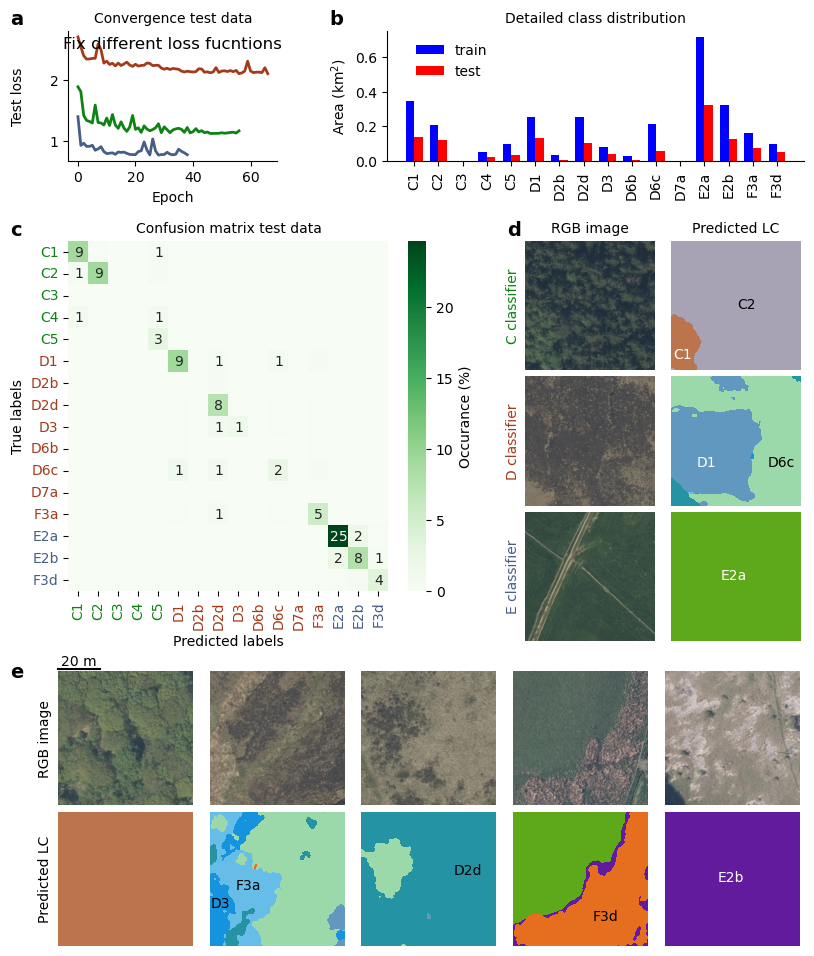

In [36]:
save_fig = False

fig = plt.figure(figsize=(8, 10), constrained_layout=False)
gs_data = fig.add_gridspec(1, 2, wspace=0.35, hspace=0.3, left=0.05, right=0.97, top=0.95, bottom=0.82, width_ratios=[1, 2])
gs_conf = fig.add_gridspec(1, 1, left=0.05, right=0.55, top=0.74, bottom=0.39)

add_cbar = False
gs_ims_1 = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.05, left=0.03, right=0.75 if add_cbar else 0.97, 
                          top=0.31, bottom=0.035)
gs_ims_2 = fig.add_gridspec(3, 2, wspace=0.05, hspace=0.05, left=0.615, right=0.97, 
                          top=0.74, bottom=0.34)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_conv = fig.add_subplot(gs_data[ 0])
for key, val in LCU_det.items():
    lcv.plot_convergence_model(model=val, ax=ax_conv, metric='val_loss', colour_line=dict_colour[key], normalise=False)
# lcv.plot_convergence_model(model=LCU_main, ax=ax_conv, metric='val_loss', colour_line=dict_colour['test'])
ax_conv.set_title('Convergence test data')
ax_conv.text(0.5, 0.9, 'Fix different loss fucntions', transform=ax_conv.transAxes, ha='center', va='center', fontsize=12)

ax_distr = fig.add_subplot(gs_data[1])
ax_distr, classes_plot = lcv.plot_distribution_train_test_classes(dict_pols_per_patch=dict_pols_detailed_rand, 
                                         plot_dual_axis=False, colour_dict=dict_colour,
                                         ax=ax_distr, dict_train_test_split=dict_tile_patches,
                                         col_name_class='Class_low', rotation_xticklabels=90)
ax_distr.set_title('Detailed class distribution')
lcv.despine(ax_distr)
ax_distr.legend(loc='upper left', bbox_to_anchor=(0.04, 1.0), frameon=False)

## prep conf mat of all models
mapping_name_to_code = lca.get_mapping_class_names_to_shortcut()[1]
mapping_name_to_code['Scrub'] = 'C4'
dict_conf_mats = {} 
total_class_name_list = []
assert len(set(classes_plot)) == len(classes_plot)
for key, model in LCU_det.items():
    conf_mat = model.test_confusion_mat 
    class_name_list = model.dict_training_details['class_name_list']
    assert conf_mat.ndim == 2 and conf_mat.shape[0] == conf_mat.shape[1] and conf_mat.shape[0] == len(class_name_list)
    if key == 'D' and 'F3d' in classes_plot:
        classes_plot = [x for x in classes_plot if x != 'F3d']
    elif key == 'E' and 'F3d' not in classes_plot:
        classes_plot = classes_plot + ['F3d']
    inds_keep = np.array([mapping_name_to_code[x] in classes_plot for x in class_name_list])
    conf_mat = conf_mat[inds_keep, :][:, inds_keep]
    class_name_list = [x for i, x in enumerate(class_name_list) if inds_keep[i]]
    total_class_name_list += class_name_list
    dict_conf_mats[key] = conf_mat

assert len(set(total_class_name_list)) == len(total_class_name_list)
assert set([mapping_name_to_code[x] for x in total_class_name_list]) == set(classes_plot), f'{[mapping_name_to_code[x] for x in total_class_name_list]} vs {classes_plot}'

total_conf_mat = np.zeros((len(classes_plot), len(classes_plot)))
start_ind = 0
n_classes_per_classifier = {}
for key, conf_mat in dict_conf_mats.items():
    n_classes_per_classifier[key] = conf_mat.shape[0]
    total_conf_mat[start_ind:(start_ind + n_classes_per_classifier[key]), :][:, start_ind:(start_ind + n_classes_per_classifier[key])] = conf_mat
    start_ind += n_classes_per_classifier[key]

ax_conf = fig.add_subplot(gs_conf[0])
tmp = lcv.plot_confusion_summary(conf_mat=total_conf_mat, normalise_hm=True, ax_hm=ax_conf,
                               class_name_list=total_class_name_list,
                               fmt_annot='.0f', print_table=False, suppress_zero_annot=True,
                               dict_override_shortcuts={'Scrub': 'C4'})
df_stats_per_detailed_class = tmp[0]
ax_conf.set_title('Confusion matrix test data')
start_ind = 0
for key, n_classes_tmp in n_classes_per_classifier.items():
    plt.setp(ax_conf.get_xticklabels()[start_ind:(start_ind + n_classes_tmp)], color=dict_colour[key])
    plt.setp(ax_conf.get_yticklabels()[start_ind:(start_ind + n_classes_tmp)], color=dict_colour[key])
    start_ind += n_classes_tmp
ax_ims = []
ax_lcs = []
for i in range(8):
    if i < 5:
        ax_ims.append(fig.add_subplot(gs_ims_1[0, i]))
        ax_lcs.append(fig.add_subplot(gs_ims_1[1, i]))
    else:
        ax_ims.append(fig.add_subplot(gs_ims_2[i-5, 0]))
        ax_lcs.append(fig.add_subplot(gs_ims_2[i-5, 1]))
    ax_ims[i].set_xticks([])
    ax_ims[i].set_yticks([])
    ax_lcs[i].set_xticks([])
    ax_lcs[i].set_yticks([])

## plot some examples
## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097
dict_examples = {'C': ['SK1091_patch051', 'SK2496_patch029'],
                  'D': ['SK0790_patch066', 'SK0790_patch089', 'SK1588_patch110'],
                  'E': ['SK0682_patch063', 'SK1258_patch191', 'SK1357_patch097']}
dict_ax_inds = {'C': [5, 0],
                'D': [6, 1, 2],
                'E': [7, 3, 4]}
# assert len(list(dict_examples.values()).join()) == 8

for key, names_examples in dict_examples.items():
    inds_examples = [int(np.where(test_ds_det[key].df_patches['patch_name'] == x)[0][0]) for x in names_examples]

    batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples)
    predicted_labels = LCU_det[key].forward(batch[0])
    predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
    ## undo preprocessing of image so the true RGB image is shown again:
    ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
    ims_plot = ims_plot.detach().numpy()
    for i in range(len(inds_examples)):
        ind_ax = dict_ax_inds[key][i]
        lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[ind_ax])
        lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[ind_ax], 
                                lc_class_name_list=test_ds_det[key].class_name_list, 
                                unique_labels_array=test_ds_det[key].unique_labels_arr,
                                plot_colorbar=False, 
                                cax=ax_cbar)
        
ax_ims[0].set_ylabel('RGB image')
ax_lcs[0].set_ylabel('Predicted LC')
ax_ims[5].set_ylabel('C classifier', color=dict_colour['C'])
ax_ims[6].set_ylabel('D classifier', color=dict_colour['D'])
ax_ims[7].set_ylabel('E classifier', color=dict_colour['E'])
ax_ims[5].set_title('RGB image')
ax_lcs[5].set_title('Predicted LC')

fig.align_ylabels([ax_conv, ax_conf]) # , ax_ims[0], ax_lcs[0]

## Plot scale bar:
xlims = ax_ims[0].get_xlim()
ylims = ax_ims[0].get_ylim()
ax_ims[0].plot([0, 512 / 64 * 20], [-10, -10], c='k', clip_on=False)
ax_ims[0].text(s='20 m', x=80, y=-12, ha='center', va='bottom', clip_on=False)
ax_ims[0].set_xlim(xlims)
ax_ims[0].set_ylim(ylims)

## LC labels:
ax_lcs[5].text(s='C1', x=10, y=450, ha='left', va='center', zorder=5, c='w')
ax_lcs[5].text(s='C2', x=300, y=250, ha='center', va='center', zorder=5, c='k')
ax_lcs[6].text(s='D1', x=140, y=340, ha='center', va='center', zorder=5, c='w')
ax_lcs[2].text(s='D2d', x=350, y=250, ha='left', va='bottom', zorder=5, c='k', clip_on=False)
ax_lcs[6].text(s='D6c', x=440, y=340, ha='center', va='center', zorder=5, c='k')
ax_lcs[7].text(s='E2a', x=250, y=250, ha='center', va='center', zorder=5, c='w')
ax_lcs[1].text(s='D3', x=5, y=350, ha='left', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[1].text(s='F3a', x=100, y=280, ha='left', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[3].text(s='F3d', x=350, y=400, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[4].text(s='E2b', x=250, y=250, ha='center', va='center', zorder=5, c='w', clip_on=False)
## Panel labels:
ax_conv.text(s='a', x=-0.28, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='b', x=1.25, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='c', x=-0.28, y=-0.6, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='d', x=2.1, y=-0.6, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='e', x=-0.28, y=-4.00, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_detailedclass_stats.pdf', dpi=300, bbox_inches='tight')

In [ ]:
## rename column name:
df_stats_per_detailed_class = df_stats_per_detailed_class.rename(columns={'class shortcut': 'Code',
                                                                          'true density': 'Density test set'})
df_stats_per_detailed_class['Classifier'] = 'C'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'].str.contains('D'), 'Classifier'] = 'D'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'].str.contains('E'), 'Classifier'] = 'E'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'] == 'F3a', 'Classifier'] = 'D'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'] == 'F3d', 'Classifier'] = 'E'
## sort by code:
df_stats_per_detailed_class = df_stats_per_detailed_class.sort_values(by='Code')
## drop columns:
df_stats_per_detailed_class = df_stats_per_detailed_class.drop(columns=['predicted density'])

In [58]:
lca.export_df_stats_to_latex(df_stats_per_detailed_class, path_latex='../figures/tables/df_stats_per_detailed_class.tex')

,\textbf{Class name},\textbf{Code},\textbf{Sensitivity},\textbf{Precision},\textbf{Density test set},\textbf{Classifier}
0,Broadleaved High Forest,C1,0.93,0.88,9.7\%,C
1,Coniferous High Forest,C2,0.92,0.99,10.0\%,C
2,Mixed High Forest,C3,nan,nan,0.0\%,C
3,Scrub,C4,0.00,nan,1.4\%,C
4,Clear Felled/New Plantings in Forest Areas,C5,1.00,0.64,2.8\%,C
5,Upland Heath,D1,0.85,0.82,11.0\%,D
6,Upland Grass Moor,D2b,0.00,nan,0.4\%,D
7,Blanket Peat Grass Moor,D2d,0.89,0.68,8.4\%,D
8,Bracken,D3,0.46,0.77,3.2\%,D
9,Upland Heath/Bracken Mosaic,D6b,0.00,nan,0.6\%,D


In [60]:
df_tmp = pd.read_json('tmp.jsonl', lines=True)
df_tmp['file_name'] = df_tmp['file_name'].apply(lambda x: os.path.join('random', 'another_ranodm', x))
df_tmp

,file_name,text
0,random/another_ranodm/0.png,Hello
1,random/another_ranodm/1.png,there


## bits & pieces

Removing NO CLASS from confusion matrix


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


adding scrub
adding wetland
adding transport


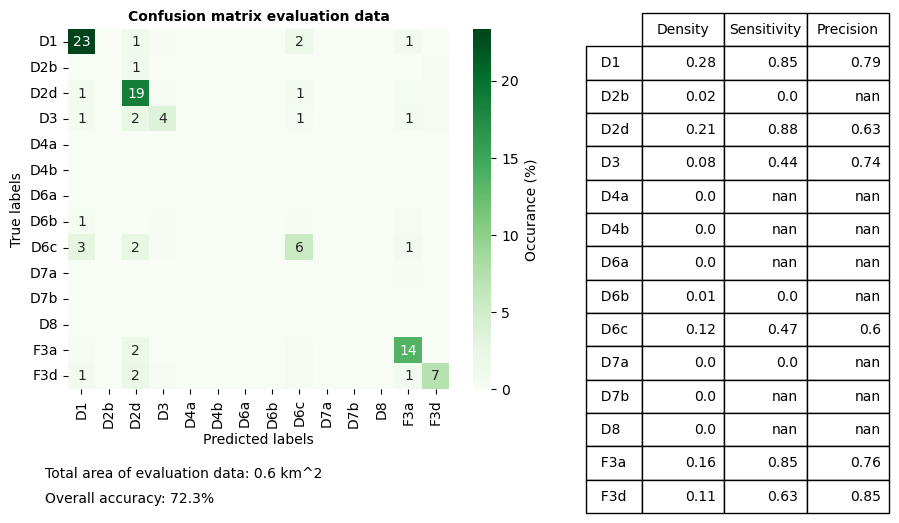

In [19]:

_ = lcv.plot_confusion_summary(model=LCU_det['D'], normalise_hm=True, text_under_mat=True,
                               fmt_annot='.0f', print_table=True, suppress_zero_annot=True)

In [20]:
_[0]

,class name,class shortcut,sensitivity,precision,true density,predicted density
0,Upland Heath,D1,0.847613,0.794910,0.275423,0.293683
1,Upland Grass Moor,D2b,0.000000,NaN,0.015412,0.000000
2,Blanket Peat Grass Moor,D2d,0.878783,0.630775,0.214598,0.298974
3,Bracken,D3,0.436501,0.737828,0.083490,0.049393
4,Unenclosed Lowland Rough Grassland,D4a,NaN,NaN,0.000000,0.000000
5,Unenclosed Lowland Heath,D4b,NaN,NaN,0.000000,0.000000
6,Upland Heath/Grass Mosaic,D6a,NaN,NaN,0.000000,0.000000
7,Upland Heath/Bracken Mosaic,D6b,0.000000,NaN,0.014445,0.000000
8,Upland Heath/Blanket Peat Mosaic,D6c,0.465761,0.597225,0.120449,0.093935
9,Eroded Bare Peat,D7a,0.000000,NaN,0.001698,0.000000


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


104


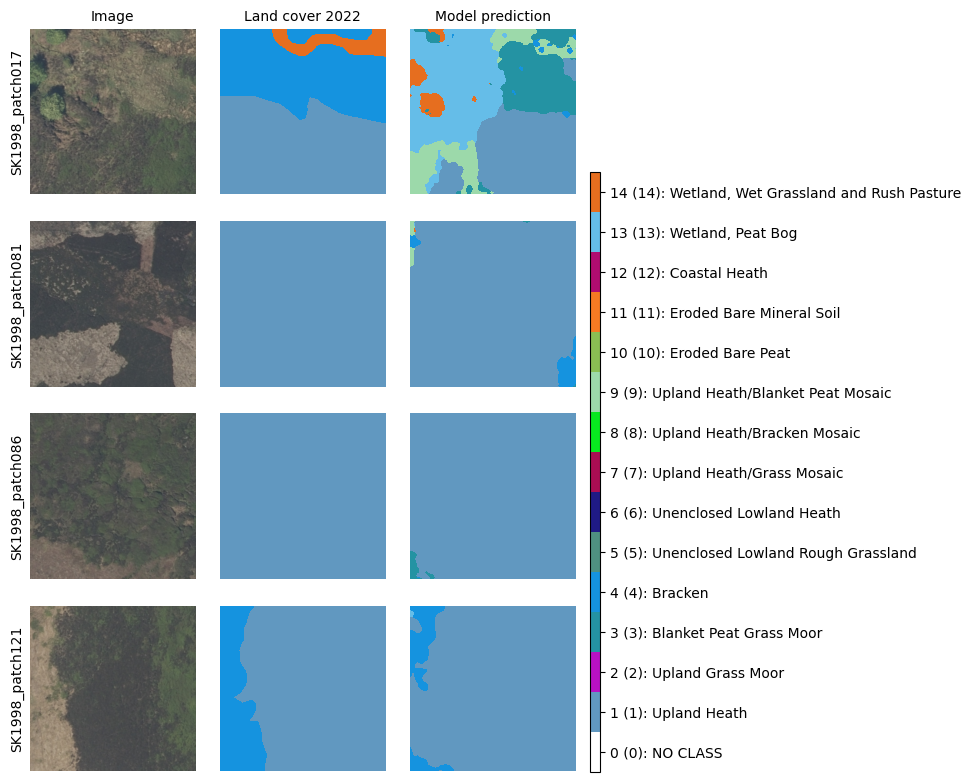

In [224]:
kk += 4
# kk = 0
key = 'D'
tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds_det[key], 
                                                 batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU_det[key], batch=tmp_batch,
                                        #  test_dl=test_dl, 
                                         preprocessing_fun=test_ds_det[key].preprocessing_func,
                                         lc_class_name_list=test_ds_det[key].class_name_list, 
                                         unique_labels_array=test_ds_det[key].unique_labels_arr,
                                         names_patches=names_patches)
print(kk)

## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097